# 1.  IMPORT LIBRARY

In [ ]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and working with arrays
import cv2 as cv  # For image processing tasks
import os  # For interacting with the operating system, like file paths
import tensorflow as tf  # For building and training neural network models

import zipfile
import os
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.models import load_model  # For loading a saved Keras model
from keras.models import Sequential  # For creating a linear stack of layers in the model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten  # For building model layers
from keras.optimizers import Adam  # For optimization algorithms
from keras.layers import BatchNormalization  # For applying Batch Normalization in neural network layers
from keras.regularizers import l2  # For applying L2 regularization to prevent overfitting
from keras.callbacks import ReduceLROnPlateau, EarlyStopping  # Importing specific callback functions

import warnings  # For handling warnings
import sys  # For interacting with the Python interpreter
if not sys.warnoptions:
    warnings.simplefilter("ignore")  # Ignore simple warnings if not already done
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore deprecation warnings

# 2. DATA LOADING

In [ ]:
# # Mount Google Drive to access the dataset
# from google.colab import drive
# drive.mount('/content/drive')
# print(drive)

from google.colab import files
uploaded = files.upload()


Saving Dataset_CK48.zip to Dataset_CK48.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("Dataset_CK48.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


# 3. EKSPLORASI DATA, DATA PREPARATION

In [ ]:
import shutil

# Define the path to your original dataset and the paths where you want to store your train and test datasets
original_dataset_dir = 'Dataset CK+48'
train_dir = 'CK+48_train'
test_dir = 'CK+48_test'

# Create directories for training and testing datasets if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the split ratio
train_ratio = 0.8

In [ ]:
# Hitung distribusi dataset asli secara otomatis
print("Distribusi dataset asli:")
class_counts = {}
total_images = 0

for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        count = len([f for f in os.listdir(emotion_dir)
                    if os.path.isfile(os.path.join(emotion_dir, f))
                    and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[emotion] = count
        total_images += count
        print(f"{emotion}: {count}")

print(f"\nTotal images: {total_images}")

# Analisis tingkat ketidakseimbangan dataset
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count
print(f"Imbalance ratio: {imbalance_ratio:.2f} (max: {max_count}, min: {min_count})")


Distribusi dataset asli:
sadness: 84
disgust: 177
happy: 207
anger: 135
fear: 75
contempt: 54
surprise: 249

Total images: 981
Imbalance ratio: 4.61 (max: 249, min: 54)


# 4. DATA SPLITTING

In [ ]:
# Split dataset dengan mempertahankan proporsi
for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]

        # Set random seed untuk reproducibility
        np.random.seed(42)
        np.random.shuffle(images)

        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]

        train_emotion_dir = os.path.join(train_dir, emotion)
        test_emotion_dir = os.path.join(test_dir, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(test_emotion_dir, exist_ok=True)

        for image in train_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
        for image in test_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

print("Dataset splitting complete")

Dataset splitting complete


Bagian kode ini bertujuan untuk memisahkan dataset gambar asli Anda, yang berisi berbagai kategori emosi, menjadi dua bagian utama: satu untuk melatih model kecerdasan buatan (disebut dataset training) dan satu lagi untuk menguji kinerja model pada data yang belum pernah dilihatnya (disebut dataset testing). Proses pemisahan ini adalah langkah penting dalam membangun model machine learning agar evaluasi model menjadi objektif.

Langkah-langkahnya dimulai dengan menentukan lokasi folder tempat dataset asli Anda berada dan menentukan nama folder baru yang akan dibuat untuk menyimpan data hasil pemisahan (untuk training dan testing). Kode kemudian memastikan bahwa kedua folder baru ini ada, jika belum ada maka akan dibuat secara otomatis.

Selanjutnya, kode menetapkan rasio pemisahan. Dalam kasus ini, rasio ditetapkan 80% untuk data training dan 20% untuk data testing.

Inti dari prosesnya adalah kode akan mengunjungi setiap kategori emosi yang ada dalam dataset asli Anda satu per satu. Untuk setiap kategori emosi (misalnya, 'senang', 'sedih', 'marah'):

1. Kode akan mengumpulkan daftar semua file gambar yang ada dalam kategori emosi tersebut.
2. Daftar gambar ini kemudian diacak secara acak. Pengacakan ini penting agar pembagian data tidak bias atau terpola.
3. Berdasarkan rasio yang sudah ditentukan (80:20), daftar gambar yang sudah diacak tersebut dibagi menjadi dua kelompok: kelompok untuk pelatihan dan kelompok untuk pengujian.
4. Kode membuat sub-folder dengan nama emosi yang sedang diproses di dalam folder training dan folder testing yang sudah dibuat sebelumnya.
5. Terakhir, gambar-gambar dari kelompok pelatihan disalin ke sub-folder emosi di dalam folder training, dan gambar-gambar dari kelompok pengujian disalin ke sub-folder emosi di dalam folder testing.

Proses ini diulang untuk semua kategori emosi dalam dataset asli. Setelah selesai, kode akan menampilkan pesan yang memberitahukan bahwa pemisahan dataset telah berhasil dilakukan. Hasilnya, Anda akan memiliki struktur folder baru yang memuat gambar-gambar emosi yang sudah terbagi rapi untuk kebutuhan training dan testing model Anda.

In [ ]:
# Hitung distribusi train set untuk class weights
train_counts = {}
for emotion in os.listdir(train_dir):
    emotion_dir = os.path.join(train_dir, emotion)
    if os.path.isdir(emotion_dir):
        count = len([f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))])
        train_counts[emotion] = count

print("\nDistribusi train set:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")


Distribusi train set:
sadness: 67
disgust: 141
happy: 165
anger: 108
fear: 60
contempt: 43
surprise: 199


# *Extraksi Dimensi dari gambar

In [ ]:
import cv2

# Load the image
img = cv2.imread('Dataset CK+48/disgust/S098_003_00000013.png')

# Get dimensions
height, width, channels = img.shape
print(f'Dimensions: {width}x{height}')

Dimensions: 48x48


Kode ini adalah langkah-langkah untuk membuat dan melatih model kecerdasan buatan agar bisa mengenali emosi pada gambar wajah.

1. Siapkan Alat & Data: Kode ini mengumpulkan semua "alat" (pustaka seperti cv2, tensorflow, keras) yang diperlukan untuk mengolah gambar dan membuat model pintar. Dataset gambar emosi asli (seperti orang senyum, sedih, marah) dipisah jadi dua: sebagian besar untuk model belajar (data latih) dan sebagian kecil untuk menguji model setelah belajar (data uji).

2. Atur Data Gambar: Gambar-gambar ini diatur lagi agar siap dipakai model. Untuk data belajar, gambar sengaja diubah-ubah sedikit secara acak (diputar, digeser, dll) setiap kali dipakai. Ini namanya augmentasi data, tujuannya biar model pintar mengenali emosi meskipun gambarnya bervariasi, dan tidak hanya menghafal gambar asli. Gambar juga dibuat kecil (48x48 piksel) dan hitam putih. Untuk data uji, gambar tidak diubah acak, hanya diatur ukurannya saja, biar hasil ujinya jujur.

3. Buat Otak Model: Kode ini membangun "otak" model (disebut CNN) yang bisa "melihat" gambar. Otak ini punya banyak lapisan yang tugasnya mengenali pola-pola penting di wajah (seperti mata, mulut, bentuk alis) dan akhirnya memutuskan emosi apa yang ada di gambar. Ada lapisan khusus yang membantu model belajar lebih stabil dan tidak gampang salah (overfitting).

4. Siapkan Belajar: Model yang sudah dibuat diatur cara belajarnya: bagaimana dia tahu kalau prediksinya salah, dan bagaimana cara dia memperbaiki diri.

5. Pasang Pengawas Belajar: Dipasang dua "pengawas" saat model belajar. Pengawas pertama menghentikan belajar kalau modelnya sudah tidak makin pintar lagi di data uji (supaya tidak buang waktu dan tidak overfitting). Pengawas kedua menurunkan kecepatan belajar kalau modelnya mulai susah meningkat pintarnya (supaya bisa mencari hasil yang lebih baik).

6. Mulai Belajar: Akhirnya, model diperintahkan untuk mulai belajar menggunakan data latih yang sudah disiapkan, sambil diawasi oleh pengawas-pengawas tadi menggunakan data uji. Proses ini akan terus berjalan sampai model dianggap cukup pintar atau sampai dihentikan oleh pengawas.

Jadi, intinya, kode ini menyiapkan gambar-gambar emosi, membuat "otak" pintar (model CNN) yang bisa "melihat" pola di gambar, mengatur cara belajar model itu, dan membiarkan model belajar di bawah pengawasan agar hasilnya maksimal.

# 5. IMAGE DATA GENERATOR

## 5.1 Membuat Training Image Data Generator

In [ ]:
# Create a data generator with augmentation
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Dikurangi dari 15 ke 10
    width_shift_range=0.1,  # Dikurangi dari 0.15 ke 0.1
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load images from the directory and apply the defined transformations
fer_training_data = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,  # Dikurangi dari 64 ke 32 untuk stabilitas
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

fer_training_data

# batch_size = fer_training_data.batch_size
# total_batches = 0
# total_images_seen = 0

# # Misal kamu mau iterasi 1 epoch (semua data asli sekali lewat)
# steps_per_epoch = len(fer_training_data)  # jumlah batch per epoch (jumlah gambar asli / batch size)

# fer_training_data.reset()

# for _ in range(steps_per_epoch):
#     images, labels = next(fer_training_data)
#     total_batches += 1
#     total_images_seen += images.shape[0]  # batch size, bisa kurang di batch terakhir

# print(f"Total batch di epoch ini: {total_batches}")
# print(f"Total gambar augmentasi yang sudah di-generate selama epoch: {total_images_seen}")



Found 783 images belonging to 7 classes.


ImageDataGenerator ini digunakan untuk augmentasi data secara real-time, yaitu menghasilkan versi berbeda dari gambar yang sama selama training berlangsung. Ini sangat penting terutama saat ukuran dataset kecil seperti CK+ (hanya 981 gambar).

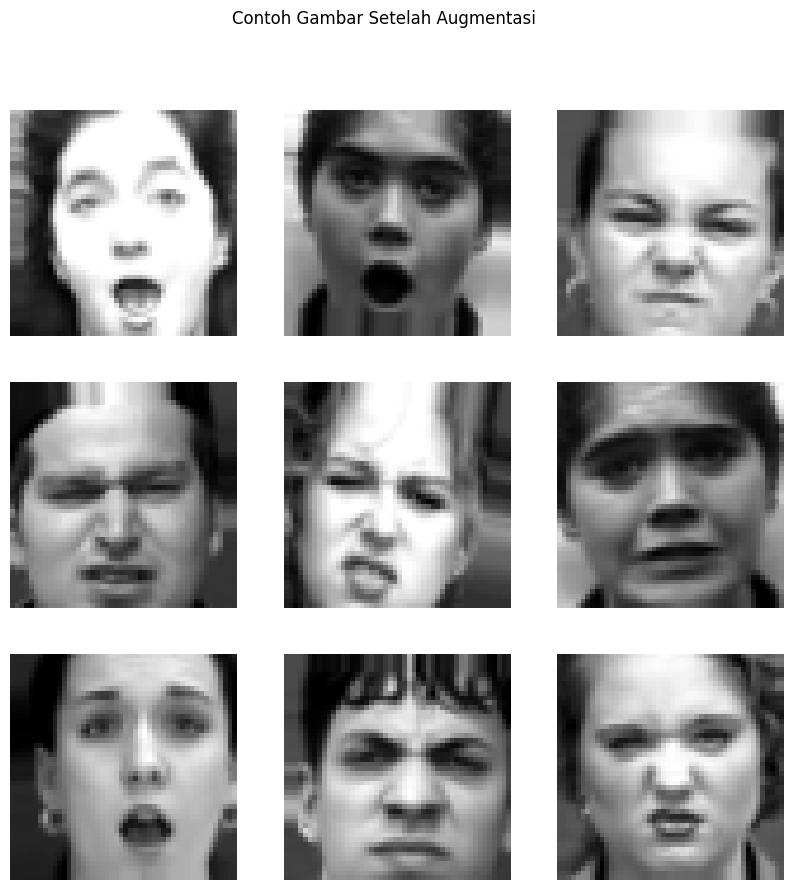

In [ ]:
import matplotlib.pyplot as plt

# Ambil batch pertama dari data generator training
images, labels = next(fer_training_data)

# Menampilkan 9 gambar hasil augmentasi pertama
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = images[i].reshape(48,48)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Contoh Gambar Setelah Augmentasi")
plt.show()


In [ ]:
# Cek indeks label
print(fer_training_data.class_indices)

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}


## 5.2 Membuat Test Image Data Generator

In [ ]:
# Initialize an ImageDataGenerator for test data with rescaling
# Rescales images by dividing pixel values by 255 (normalization)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Creates a data generator for the test dataset
# flow_from_directory method loads images from a directory,
# in this case, '/kaggle/working/CK+48_test'
fer_test_data = test_data_generator.flow_from_directory(
    '/content/CK+48_test',  # Directory path for test images
    target_size = (48, 48),  # Resizes images to 48x48 pixels
    batch_size = 64,  # Number of images to yield per batch
    color_mode = 'grayscale',  # Specifies that images are in grayscale
    class_mode = 'categorical',  # Images are classified categorically
    shuffle=False
)

# fer_test_data is now a generator that yields batches of test images and their labels
fer_test_data

Found 198 images belonging to 7 classes.


Tahapan ini membuat generator (fer_test_data) dari folder berisi gambar uji, yang telah:

* Di-resize ke ukuran 48x48 piksel,
* Dinormalisasi (skala piksel jadi 0–1),
* Dikonversi ke format grayscale,
* Dan labelnya dikodekan secara kategorikal.

Semua ini tanpa augmentasi, karena tujuannya adalah untuk menguji performa akhir model secara obyektif.

# 6. PEMBANGUNAN MODEL

## 6.1 Class Weight

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Hitung class weights untuk menangani imbalanced dataset
class_names = list(fer_training_data.class_indices.keys())
class_weights_values = compute_class_weight(
    'balanced',
    classes=np.unique(fer_training_data.classes),
    y=fer_training_data.classes
)
class_weights = dict(zip(range(len(class_names)), class_weights_values))

print("\nClass weights untuk menangani imbalanced dataset:")
for i, (class_name, weight) in enumerate(zip(class_names, class_weights_values)):
    print(f"{class_name}: {weight:.4f}")


Class weights untuk menangani imbalanced dataset:
anger: 1.0357
contempt: 2.6013
disgust: 0.7933
fear: 1.8643
happy: 0.6779
sadness: 1.6695
surprise: 0.5621


## 6.2 Optimalisasi

In [ ]:
# Importing the optimizers module from TensorFlow's Keras library
from tensorflow.keras import optimizers

# Initializing a list of optimizers with specific configurations
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

Algoritma ini, yang disebut optimizer, bertugas mengatur bagaimana model belajar dengan menyesuaikan parameter-parameternya (seperti bobot) berdasarkan data pelatihan, agar model bisa memprediksi dengan lebih akurat.

Jadi, ini adalah langkah untuk memilih "metode belajar" yang akan digunakan model nanti.

# *Clear Session

In [ ]:
# from tensorflow.keras import backend as K

# # Misal model sudah dibuat dan dipakai, lalu ingin clear
# K.clear_session()


# 6.3 Perancangan Arsitektur Model CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(
        Conv2D(
            filters=512,
            kernel_size=(5,5),
            input_shape=(48, 48, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
        Conv2D(
            filters=256,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
model.add(BatchNormalization(name='batchnorm_2'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.25, name='dropout_1'))

model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
model.add(BatchNormalization(name='batchnorm_4'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.25, name='dropout_2'))

model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
model.add(BatchNormalization(name='batchnorm_6'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.25, name='dropout_3'))

model.add(Flatten(name='flatten'))

model.add(
        Dense(
            256,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_7'))

model.add(Dropout(0.25, name='dropout_4'))

model.add(
        Dense(
            7,
            activation='softmax',
            name='out_layer'
        )
    )

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 512)    │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 256)    │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,937,159 (37.91 MB)

 Trainable params: 9,933,063 (37.89 MB)

 Non-trainable params: 4,096 (16.00 KB)

Kode Python ini intinya melakukan langkah-langkah persiapan data dan pembuatan model untuk mengenali emosi dari gambar wajah.

1. Persiapan Awal: Kode pertama-tama mengimpor semua alat yang dibutuhkan, seperti pustaka untuk mengolah data (numpy, pandas), gambar (cv2), mengelola file (os, shutil), dan membangun serta melatih jaringan saraf tiruan (tensorflow, keras). Beberapa pengaturan juga dibuat untuk mengabaikan peringatan yang tidak penting.

2. Membagi Data Gambar: Dataset gambar emosi yang asli (di /kaggle/input/ckplus/CK+48) dipisahkan menjadi dua kelompok: 80% untuk melatih model (folder CK+48_train) dan 20% untuk menguji seberapa baik model bekerja setelah dilatih (folder CK+48_test). Proses ini memastikan model diuji pada gambar yang belum pernah dilihatnya saat pelatihan.

3. Menyiapkan Data untuk Model (Generator Data): Kode membuat "generator data" untuk data pelatihan dan pengujian.
  - Generator data pelatihan tidak hanya memuat gambar, tapi juga secara acak mengubah gambar sedikit (diputar, digeser, diperbesar/diperkecil) setiap kali model membutuhkan data. Ini disebut augmentasi data, tujuannya agar model belajar mengenali emosi meskipun gambarnya bervariasi, dan juga membantu model tidak hanya "menghafal" gambar pelatihan (overfitting). Gambar-gambar ini juga diubah ukurannya menjadi 48x48 piksel dan dijadikan hitam putih (grayscale).
  - Generator data pengujian hanya memuat gambar dan mengubah ukurannya (48x48 piksel, grayscale) tanpa melakukan perubahan acak (augmentasi). Ini agar pengujian model lebih objektif.
4. Membangun Model (Jaringan Saraf Tiruan): Kode mendefinisikan struktur model yang akan digunakan untuk mengenali emosi. Ini adalah jenis model yang bagus untuk gambar, namanya CNN (Convolutional Neural Network). Model ini terdiri dari beberapa lapisan yang bertugas mengekstraksi fitur penting dari gambar (seperti garis, sudut, atau bentuk wajah) dan kemudian menggunakan fitur-fitur ini untuk memutuskan emosi apa yang ada di gambar. Lapisan-lapisan penting termasuk:
  - Lapisan Conv2D untuk menemukan pola-pola dalam gambar.
  - Lapisan MaxPooling2D untuk memperkecil gambar setelah menemukan pola, mengurangi detail yang tidak perlu.
  - Lapisan BatchNormalization dan Dropout untuk membantu pelatihan model menjadi lebih stabil dan mencegah overfitting.
  - Lapisan Flatten untuk mengubah data gambar yang berdimensi menjadi satu baris data.
  - Lapisan Dense (terhubung penuh) yang menerima data dari lapisan sebelumnya dan pada akhirnya membuat keputusan akhir. Lapisan terakhir memiliki 7 neuron, satu untuk setiap kategori emosi yang ingin dikenali, dan menggunakan aktivasi softmax untuk memberikan probabilitas setiap emosi.
5. Mengkonfigurasi Model untuk Pelatihan: Model yang sudah dibangun kemudian dikonfigurasi sebelum dilatih. Ditentukan:
  - loss: Cara model mengukur seberapa salah prediksinya (categorical_crossentropy).
  - optimizer: Metode yang digunakan model untuk belajar dari kesalahan dan memperbaiki dirinya (adam).
  - metrics: Ukuran kinerja yang akan dipantau selama pelatihan (accuracy, yaitu persentase prediksi yang benar).

Jadi, secara ringkas, kode ini menyiapkan dataset gambar emosi, membuat cara untuk memuat dan memvariasikan data (augmentasi), lalu mendefinisikan struktur model CNN untuk mengenali emosi, dan terakhir mempersiapkan model tersebut untuk memulai proses pelatihan.

# 7. TRAINING THE MODEL

## 7.1 Callback

In [ ]:
# Reduce learning rate when a metric has stopped improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=8, # Lebih rendah dari 11
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,  # Lebih rendah dari 7
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

Kode ini adalah persiapan awal untuk membuat program yang bisa mengenali emosi dari gambar wajah.

1. Siapkan Alat & Data: Pertama, kode mengumpulkan semua "alat" (pustaka) yang dibutuhkan untuk mengolah data gambar dan membuat model pintar (jaringan saraf). Dataset gambar emosi asli (misalnya, gambar orang tersenyum, sedih) dipisah jadi dua kelompok: untuk "belajar" (latih) dan untuk "ujian" (uji). Ini penting biar model diuji pakai gambar yang belum pernah dilihatnya.

2. Siapkan Data untuk Belajar & Ujian: Gambar-gambar yang sudah dipisah diatur lagi. Untuk belajar, gambar-gambar ini sengaja diubah-ubah sedikit secara acak (diputar, digeser) setiap kali dipakai. Tujuannya biar model jadi pintar dan bisa mengenali emosi meskipun gambarnya agak beda-beda. Untuk ujian, gambar hanya diatur ukurannya tanpa diubah acak, biar hasilnya jujur. Semua gambar juga dijadikan ukuran kecil (48x48) dan hitam putih.

3. Buat Model Pintar: Kode membangun "otak" model (disebut CNN) yang bisa "melihat" gambar. Otak ini terdiri dari beberapa bagian (lapisan) yang tugasnya mengenali pola-pola penting di wajah (seperti mata, mulut) dan akhirnya memutuskan emosi apa yang ada di gambar.

4. Atur Cara Model Belajar: Model yang sudah dibuat diatur cara belajarnya. Ditentukan bagaimana model tahu kalau prediksinya salah, bagaimana cara dia memperbaiki diri, dan apa ukurannya kalau dia sudah pintar (misalnya, akurasi).

5. Pasang Pengawas Belajar: Dipasang dua "pengawas" saat model belajar. Pengawas pertama (EarlyStopping) akan menghentikan proses belajar kalau modelnya sudah tidak makin pintar lagi di data ujian, biar modelnya tidak "menghafal" data belajar saja. Pengawas kedua (ReduceLROnPlateau) akan menurunkan kecepatan belajar model kalau sudah mulai lambat peningkatannya, supaya model bisa mencari hasil yang lebih baik.

Singkatnya, kode ini memilah gambar-gambar emosi, menyiapkannya agar mudah diproses oleh model pintar (dengan sedikit "variasi" untuk belajar dan tanpa variasi untuk ujian), membuat struktur model pintar yang cocok untuk gambar, mengatur cara model belajar, dan memasang pengawas supaya proses belajarnya efektif dan tidak buang-buang waktu.

## 7.2 Melakukan Training Model

In [ ]:
batch_size = 64
history = model.fit(
    fer_training_data,
    epochs=60, # Dikurangi untuk mencegah overfitting
    validation_data=fer_test_data,
    class_weight=class_weights,
    batch_size = 64,
    callbacks=callbacks,
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.2769 - loss: 2.5108 - val_accuracy: 0.4899 - val_loss: 38.5461 - learning_rate: 0.0010
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5401 - loss: 1.4012 - val_accuracy: 0.2828 - val_loss: 18.7185 - learning_rate: 0.0010
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6349 - loss: 1.1021 - val_accuracy: 0.6111 - val_loss: 2.2685 - learning_rate: 0.0010
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.6776 - loss: 0.8956 - val_accuracy: 0.7980 - val_loss: 0.8056 - learning_rate: 0.0010
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7538 - loss: 0.8152 - val_accuracy: 0.8333 - val_loss: 0.5526 - learning_rate: 0.0010
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6967 - loss: 0.8974 - val_accuracy: 0.7980 - val_loss: 0.5239 - learning_rate: 0.0010
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7879 - loss: 0.6197 - val_accurac

## 7.3 Visualisasi Hasil Training

In [ ]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

# Training vs. Validation Accuracy
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)), y=history.history['accuracy'], mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)), y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))

# Layout for Accuracy
fig.update_layout(title='Training vs. Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy', template="plotly_white")

# Show the plot
fig.show()

# New figure for loss
fig = go.Figure()

# Training vs. Validation Loss
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'], mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)), y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'))

# Layout for Loss
fig.update_layout(title='Training vs. Validation Loss', xaxis_title='Epoch', yaxis_title='Loss', template="plotly_white")

# Show the plot
fig.show()

# 8. MODEL EVALUATION

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(fer_test_data, verbose=1)

# Print the loss and accuracy
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0540
Validation Loss: 0.04178641363978386
Validation Accuracy: 100.00%


Kode ini adalah bagian akhir dari serangkaian langkah dalam membangun dan melatih model kecerdasan buatan (dalam hal ini, jaringan saraf tiruan) untuk mengenali emosi dari gambar. Setelah semua persiapan data (membagi dataset, menyiapkan generator data untuk pelatihan dan pengujian) dan pendefinisian struktur model selesai, bagian kode ini adalah momen di mana model mulai belajar.

Secara ringkas, baris kode ini memerintahkan model yang telah dibuat untuk melakukan proses pelatihan (training). Proses pelatihan ini akan menggunakan data yang disiapkan sebelumnya.

Ada beberapa parameter penting yang ditentukan dalam perintah pelatihan ini:

1. Ukuran Batch (batch_size): Ini mengatur berapa banyak gambar yang diproses oleh model dalam satu "gelombang" sebelum model menyesuaikan pengaturannya (disebut bobot) untuk belajar. Dalam kode ini, setiap gelombang terdiri dari 64 gambar.
2. Data Pelatihan: Model akan menggunakan generator data pelatihan (fer_training_data) yang sebelumnya sudah disiapkan. Generator ini bertugas memasok gambar-gambar pelatihan (yang sudah diubah ukurannya, dinormalisasi, dan mungkin diaugmentasi atau divariasikan secara acak untuk membantu model belajar lebih baik) kepada model dalam batch-batch berukuran 64.
3. Jumlah Epoch (epochs): Ini menentukan berapa kali model akan "melihat" seluruh dataset pelatihan. Dalam kode ini, model diatur untuk dilatih hingga 60 kali melewati seluruh data pelatihan. Namun, proses ini bisa berhenti lebih cepat.
4. Data Validasi (validation_data): Selama pelatihan, model juga akan dievaluasi secara berkala (setelah setiap epoch) menggunakan generator data pengujian (fer_test_data). Data pengujian ini adalah gambar yang belum pernah dilihat model saat pelatihan. Evaluasi pada data validasi ini penting untuk memantau seberapa baik model bisa mengenali emosi pada gambar baru dan untuk mendeteksi apakah model mulai "menghafal" data pelatihan (overfitting).
5. Callback (callbacks): Ini adalah "pengawas" atau fungsi tambahan yang dijalankan selama pelatihan. Sebelumnya sudah didefinisikan dua callback: satu untuk menghentikan pelatihan lebih awal jika akurasi model pada data validasi sudah tidak meningkat lagi setelah beberapa epoch (ini mencegah overfitting dan menghemat waktu), dan satu lagi untuk menurunkan kecepatan belajar model jika peningkatannya mulai melambat (ini bisa membantu model menemukan kinerja yang lebih baik). Kedua pengawas ini aktif selama proses model.fit().

Hasil dari proses pelatihan ini, termasuk informasi tentang akurasi dan kerugian (loss) pada data pelatihan dan validasi di setiap epoch, akan disimpan dalam variabel history. Variabel history ini biasanya digunakan untuk membuat grafik dan menganalisis performa model selama pelatihan.

Jadi, secara keseluruhan, kode ini adalah perintah untuk memulai pembelajaran model menggunakan data pelatihan, dengan pengawasan pada data pengujian, dan diatur agar berhenti atau menyesuaikan diri demi mendapatkan performa terbaik.

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step


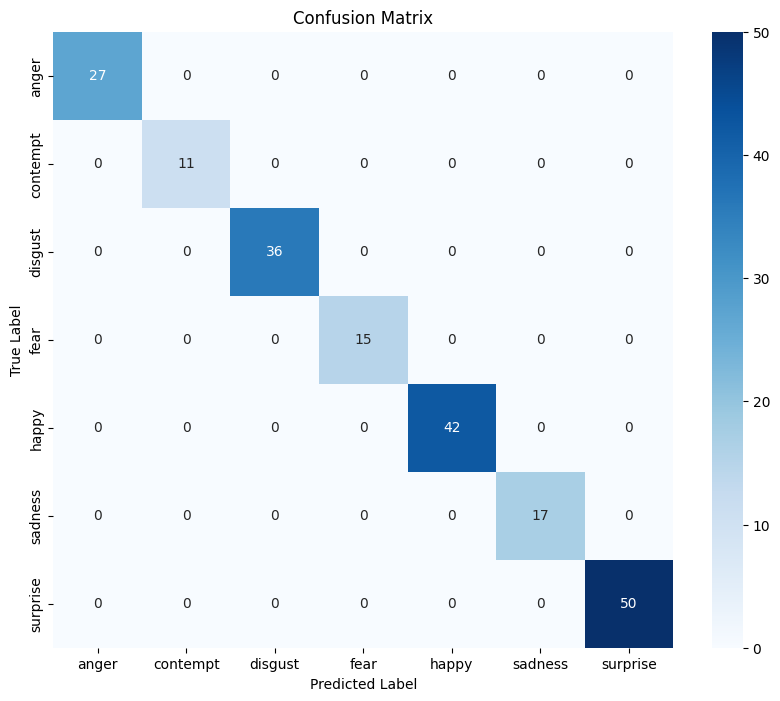


Akurasi per Ekspresi:
anger: 1.0000
contempt: 1.0000
disgust: 1.0000
fear: 1.0000
happy: 1.0000
sadness: 1.0000
surprise: 1.0000


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Mendapatkan label sebenarnya dan prediksi
# Reset generator untuk memastikan urutan yang sama
fer_test_data.reset()
Y_pred = model.predict(fer_test_data)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai prediksi
y_pred_classes = np.argmax(Y_pred, axis=1)
# Mendapatkan label sebenarnya dari generator
y_true = fer_test_data.classes

# Mendapatkan nama-nama kelas dari generator
class_labels = list(fer_test_data.class_indices.keys())

# 2. Membuat Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 3. Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4. Menghitung Akurasi per Kelas
# Akurasi per kelas = (Jumlah True Positif) / (Jumlah Data Sebenarnya di Kelas Tersebut)
# True Positif untuk setiap kelas ada di diagonal confusion matrix
diagonal = np.diag(conf_matrix)
# Jumlah total data untuk setiap kelas adalah jumlah baris di confusion matrix
row_sums = conf_matrix.sum(axis=1)

accuracy_per_class = diagonal / row_sums

print("\nAkurasi per Ekspresi:")
for i in range(len(class_labels)):
    print(f"{class_labels[i]}: {accuracy_per_class[i]:.4f}")

In [ ]:
# Save the model
model.save('facial_expression_model.h5')
print("Model saved as 'facial_expression_model.h5'")

Model saved as 'facial_expression_model.h5'
